# Analyze Breath Hold Data

In [29]:
%matplotlib inline

import os 
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from nltools.data import Brain_Data, Adjacency, Design_Matrix
from nltools.file_reader import onsets_to_dm
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import regress
from nltools.plotting import component_viewer
from nilearn.plotting import plot_img_on_surf, plot_stat_map, plot_glass_brain, view_img_on_surf
import nibabel as nib
import mne
from mne.io import read_raw_snirf
import mne.io.snirf
from snirf import Snirf
import h5py
from kernel.utils import load_snirf_file, get_resource_path, get_optodes, extract_stimulus_data, pick_channels_from_distance_mne_epochs

mne.viz.set_3d_backend("notebook")

base_dir = '/Users/lukechang/Dropbox/Kernel'

## Analyze NIFTI Reconstruction with nltools

To speed up loading data, we save a resampled version of the data. Alternatively, we could load it in the original 4 x 4 x 4 space like we do using nibabel below.

The nifti reconstructed data has been trimmed to 1 sec before start experiment and 1 sec after experiment end.

We are seeing large scaling differences across regions, so z-scoring data for now, but that means we are losing absolute HbO concentrations

Mask is s k=50 whole brain parcellation based on neurosynth coactivations. Target ROIs correspond to left and right somatomotor cortex

In [14]:
metadata = {'subject':'S001', 'task_name':'BreathHold', 'task_id':'425a0c7'}

# data_nifti = Brain_Data(os.path.join(base_dir, 'Data', metadata["task_name"],  f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO.nii.gz') )
# data_nifti.write(os.path.join(base_dir, 'Data', metadata["task_name"],  f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO_resampled.nii.gz'))

data_nifti = Brain_Data(os.path.join(base_dir, 'Data', metadata["task_name"], f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO_resampled.nii.gz') )
data_nifti = data_nifti.standardize(method='zscore')
toffset =  nib.load(os.path.join(base_dir, 'Data', metadata["task_name"], f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO.nii.gz')).header['toffset']
n_tr = len(data_nifti)

/opt/anaconda3/envs/mne/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


### Create Design_Matrix

Extract event information and plot average activity within each ROI

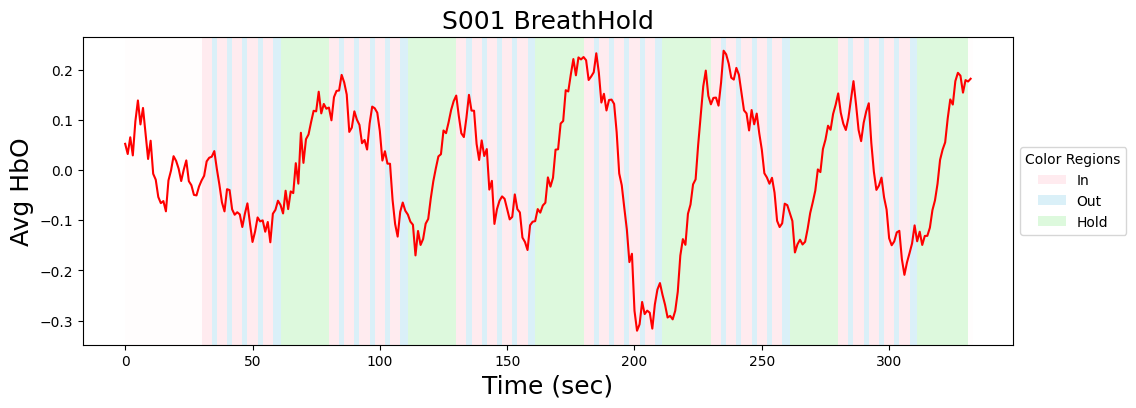

In [56]:
events = pd.read_csv(os.path.join(base_dir, 'Data', metadata['task_name'], f'Test_{metadata["subject"]}_{metadata["task_id"]}_task_events.tsv'), sep='\t')
events['timestamp_adjusted'] = events['timestamp'] - toffset

dm = onsets_to_dm(events[['timestamp_adjusted','duration','event']].rename(columns={'timestamp_adjusted':'Onset','duration':'Duration','event':'Stim'}), sampling_freq=1.0, run_length=n_tr)

# Generate Plot
f,a = plt.subplots(1, figsize=(12,4))

mean_brain = data_nifti.mean(axis=1)
a.plot(mean_brain, color='red')

# Add colored backgrounds for each integer
colors={'start_in':'pink', 'start_out':'skyblue','start_breath_hold':'lightgreen', 'rest':'snow'}
for i,row in dm.iterrows():
    if row['start_in'] == 1:
        a.axvspan(i, i+1, facecolor=colors['start_in'], alpha=0.3)
    elif row['start_out'] == 1:
        a.axvspan(i, i+1, facecolor=colors['start_out'], alpha=0.3)
    elif row['start_breath_hold']:
        a.axvspan(i, i+1, facecolor=colors['start_breath_hold'], alpha=0.3)
    else:
        a.axvspan(i, i+1, facecolor=colors['rest'], alpha=0.3)

a.set_xlabel('Time (sec)', size=18)
a.set_ylabel('Avg HbO', size=18)
legend_elements = [
    Patch(facecolor=colors['start_in'], alpha=0.3, label='In'),
    Patch(facecolor=colors['start_out'], alpha=0.3, label='Out'),
    Patch(facecolor=colors['start_breath_hold'], alpha=0.3, label='Hold'),
]
a.legend(handles=legend_elements, title='Color Regions', loc='center left', bbox_to_anchor=(1, 0.5))
a.set_title(f"{metadata['subject']} {metadata['task_name']}", size=18)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_AverageActivity_Experiment.png"), dpi=150)
plt.show()


### Frequency Analysis

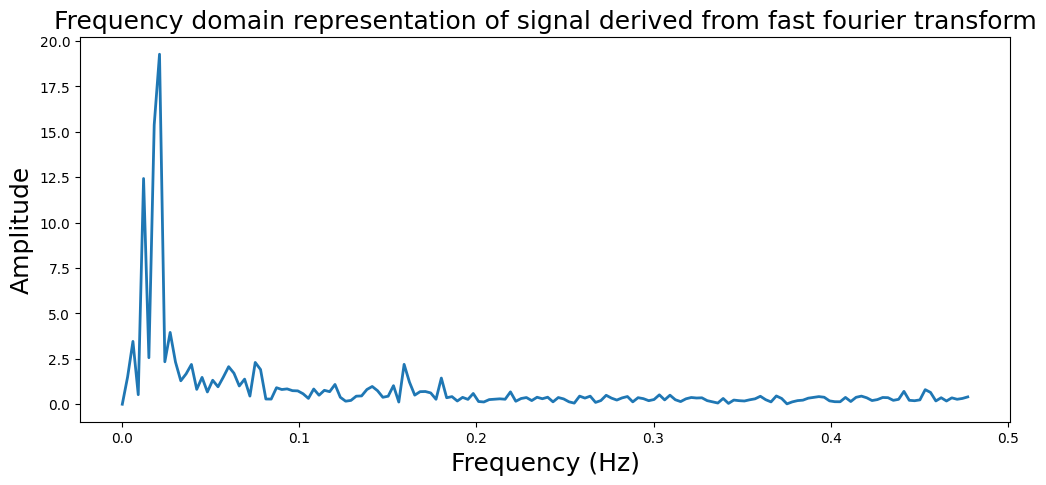

In [18]:
from numpy.fft import fft, ifft, fftfreq

sampling_freq = 1

fourier_fft = fft(mean_brain)
freq = fftfreq(len(mean_brain), 1/sampling_freq)

plt.figure(figsize=(12,5))
plt.plot(freq[:160], np.abs(fourier_fft[0:160]), linewidth=2)
plt.ylabel('Amplitude', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.title('Frequency domain representation of signal derived from fast fourier transform', fontsize=18)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_Spectrogram.png"), dpi=150)

plt.show()

### ICA
MNE seems to be screwing up our interactive widgets


/opt/anaconda3/envs/mne/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/5b/m183lc3x27n9krrzz85z2x1c0000gn/T/ipykernel_41066/3218516558.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


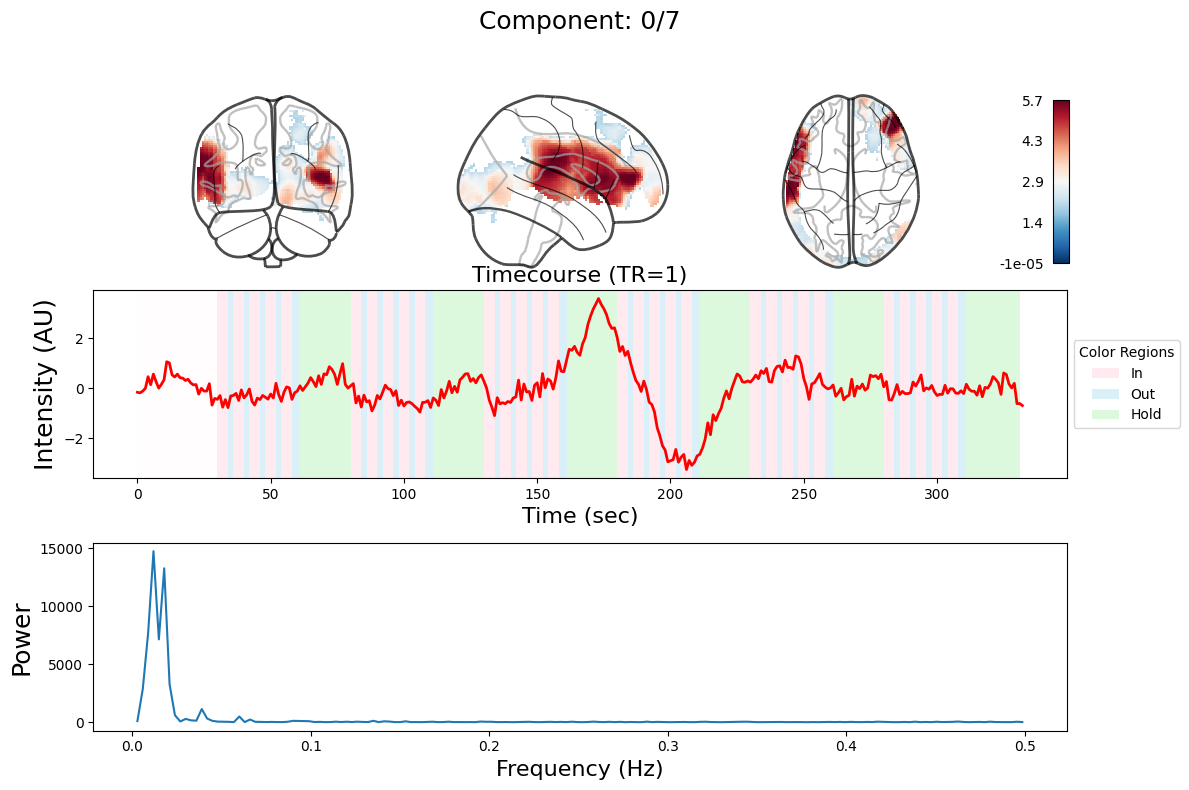

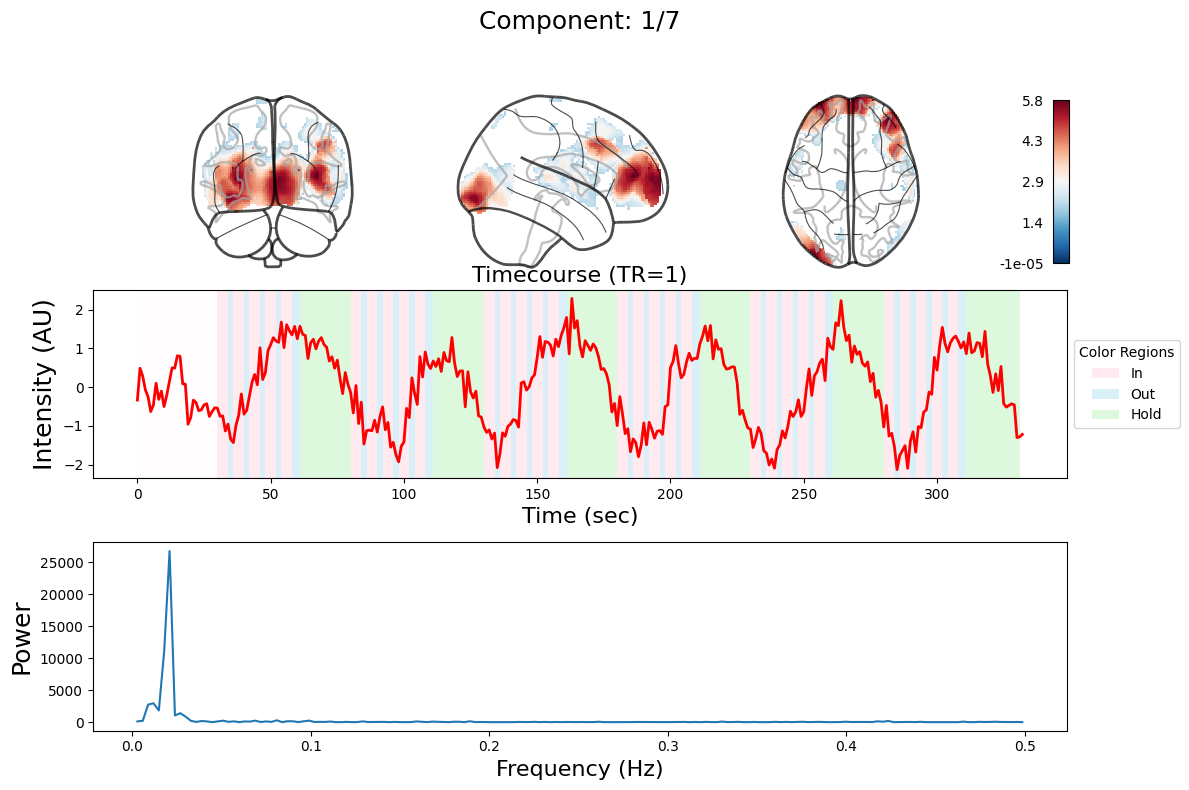

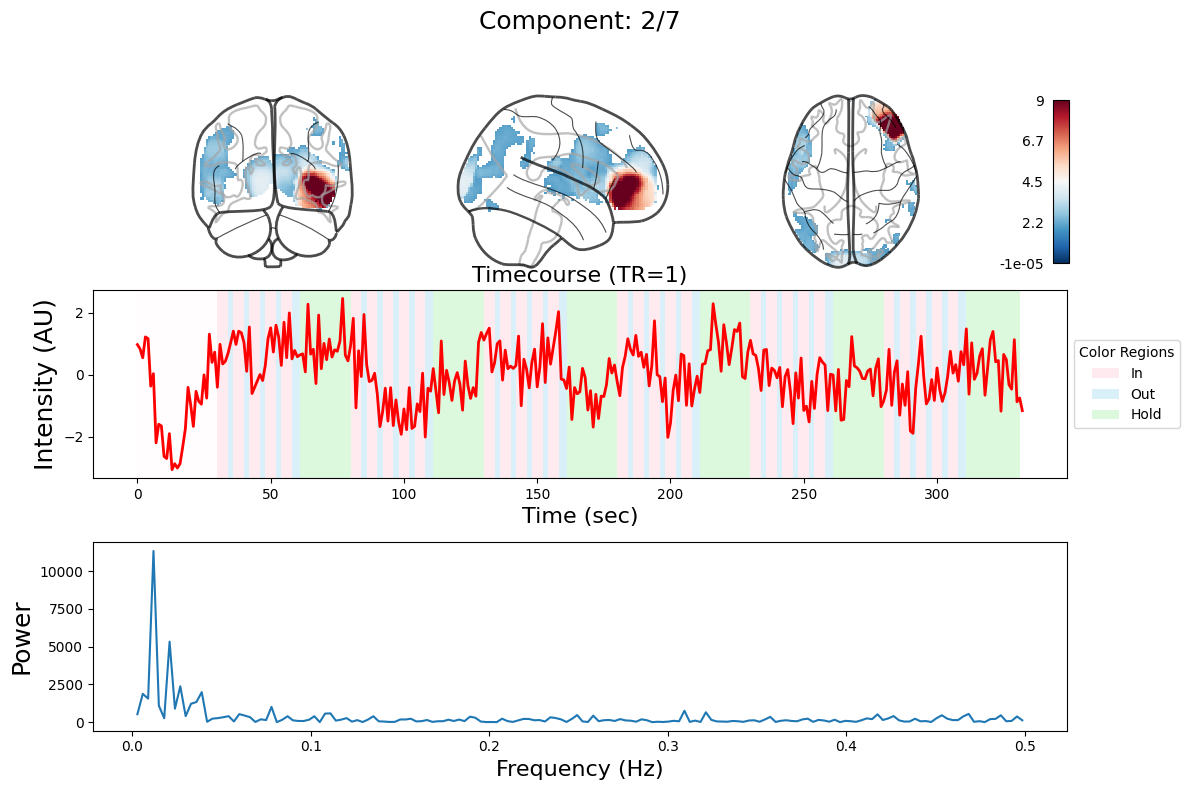

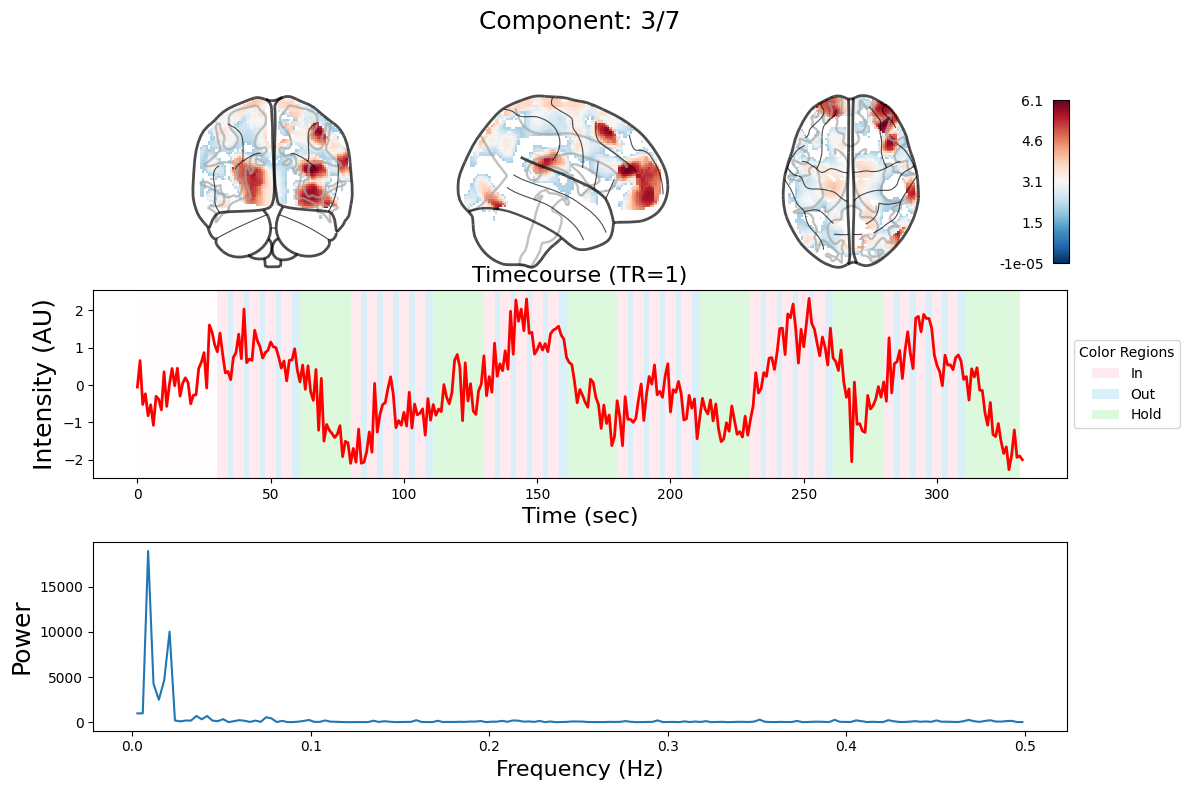

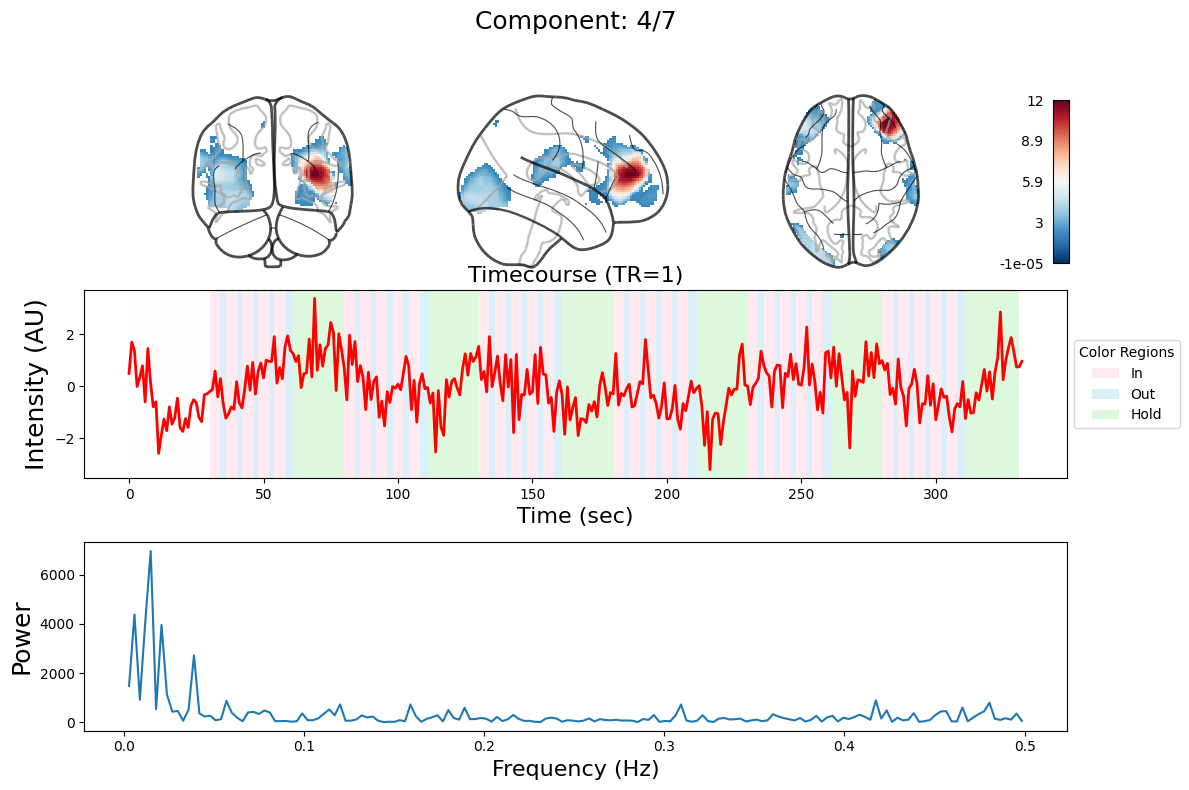

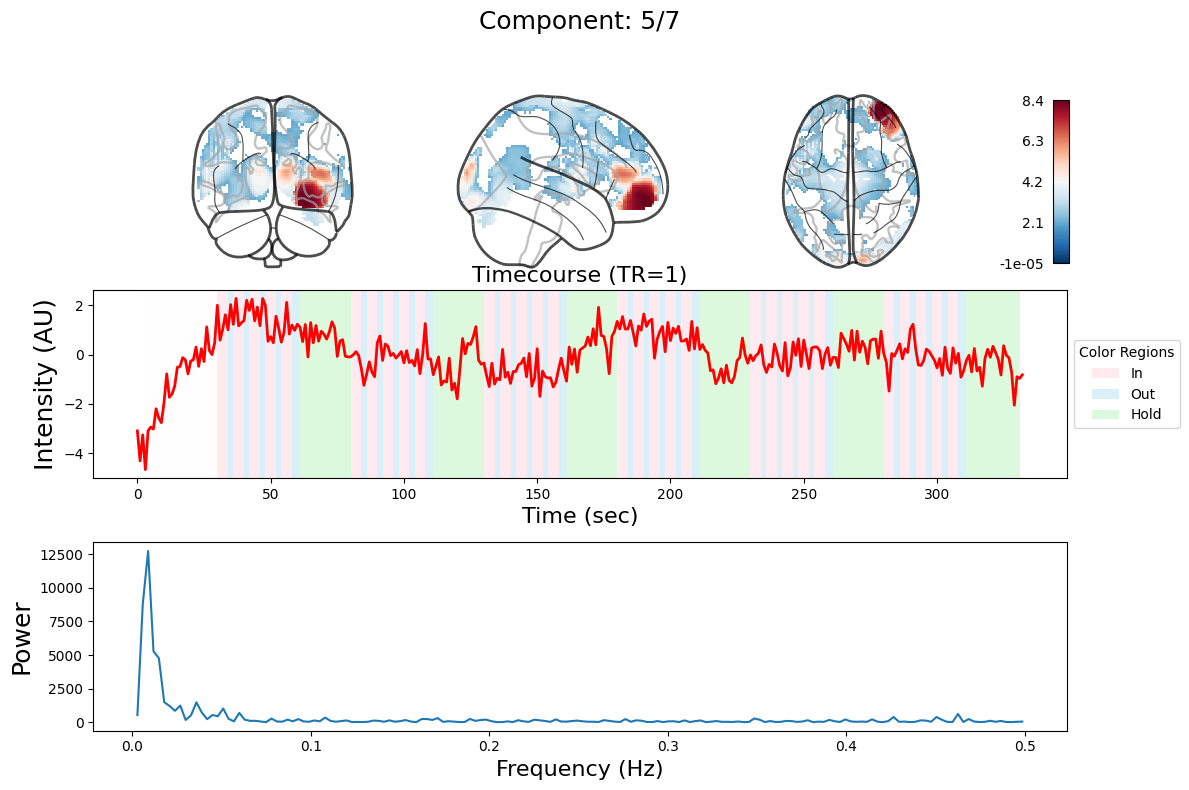

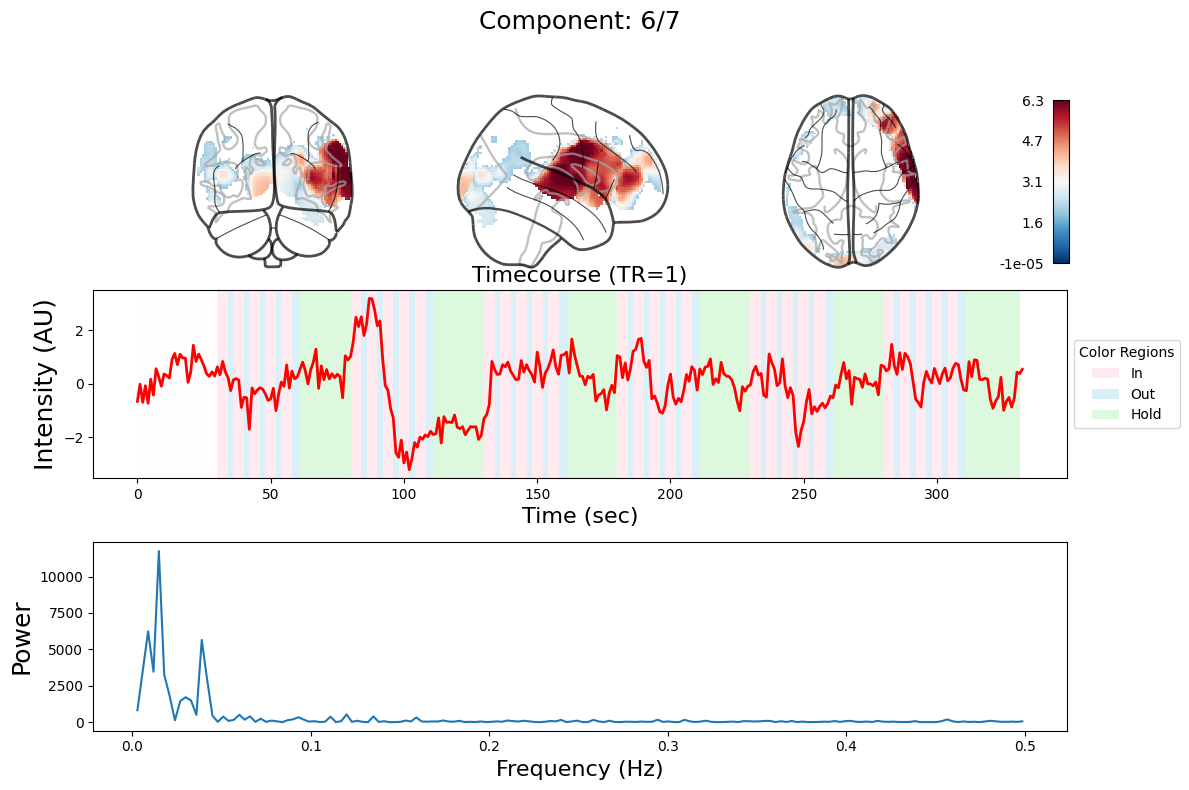

In [63]:
n_components = 7
threshold = 2

output = data_nifti.decompose(algorithm='ica', n_components=n_components)

# component_viewer(output)

component = i
for component in range(n_components):
    _, ax = plt.subplots(nrows=3, figsize=(12, 8))
    
    thresholded = (
        output["components"][component] - output["components"][component].mean()
    ) * (1 / output["components"][component].std())
    thresholded.data[np.abs(thresholded.data) <= threshold] = 0
    
    plot_glass_brain(
        thresholded.to_nifti(),
        display_mode="ortho",
        black_bg=False,
        colorbar=True,
        annotate=False,
        draw_cross=False,
        cmap='RdBu_r',
        axes=ax[0],
    )
    ax[0].set_title(
        f"Component: {component}/{len(output['components'])}", fontsize=18
    )
    
    ax[1].plot(output["weights"][:, component], linewidth=2, color="red")
    
    colors={'start_in':'pink', 'start_out':'skyblue','start_breath_hold':'lightgreen', 'rest':'snow'}
    for i,row in dm.iterrows():
        if row['start_in'] == 1:
            ax[1].axvspan(i, i+1, facecolor=colors['start_in'], alpha=0.3)
        elif row['start_out'] == 1:
            ax[1].axvspan(i, i+1, facecolor=colors['start_out'], alpha=0.3)
        elif row['start_breath_hold']:
            ax[1].axvspan(i, i+1, facecolor=colors['start_breath_hold'], alpha=0.3)
        else:
            ax[1].axvspan(i, i+1, facecolor=colors['rest'], alpha=0.3)
    
    ax[1].set_xlabel('Time (sec)', size=16)
    ax[1].set_ylabel('Avg HbO', size=18)
    legend_elements = [
        Patch(facecolor=colors['start_in'], alpha=0.3, label='In'),
        Patch(facecolor=colors['start_out'], alpha=0.3, label='Out'),
        Patch(facecolor=colors['start_breath_hold'], alpha=0.3, label='Hold'),
    ]
    ax[1].legend(handles=legend_elements, title='Color Regions', loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax[1].set_ylabel("Intensity (AU)", fontsize=18)
    ax[1].set_title(f"Timecourse (TR=1)", fontsize=16)
    
    y = fft(output["weights"][:, component])
    f = fftfreq(len(y), d=1)
    ax[2].plot(f[f > 0], np.abs(y)[f > 0] ** 2)
    ax[2].set_ylabel("Power", fontsize=18)
    ax[2].set_xlabel("Frequency (Hz)", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_ICA_component{component}.png"), dpi=150)
    plt.show()